In [42]:
from __future__ import annotations

from dataclasses import dataclass, replace, field
from typing import List, Literal, Optional, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== library imports (your refactored code) =====
import qresearch.signals as qsigs
from qresearch.data.utils import get_processed_dir
from qresearch.data.yfinance import *
from qresearch.backtest.portfolio import *
from qresearch.backtest.metrics import *
from qresearch.portfolio.weights import *

# -----------------------------
# Parquet -> MarketData
# -----------------------------
def _read_wide(path: str) -> pd.DataFrame:
    df = pd.read_parquet(path)
    # Ensure DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()
    # Ensure string tickers
    df.columns = df.columns.astype(str)
    return df


def load_marketdata_from_parquet(
    data_dir: str,
    tickers: list[str],
    start: str,
    end: Optional[str] = None,
    strict_calendar: bool = True,
) -> MarketData:
    """
    Load wide parquet panels and convert to MarketData.

    strict_calendar=True:
      - use close as master calendar
      - drop any dates where ANY selected ticker has missing close
    """
    tickers = [str(t).strip() for t in tickers]

    # Required
    close = _read_wide(f"{data_dir}/ohlcv_wide_close.parquet")

    # Optional panels (load if present)
    def maybe(panel_name: str) -> pd.DataFrame | None:
        p = f"{data_dir}/ohlcv_wide_{panel_name}.parquet"
        try:
            return _read_wide(p)
        except Exception:
            return None

    open_ = maybe("open")
    high = maybe("high")
    low = maybe("low")
    volume = maybe("volume")
    turnover = maybe("turnover")
    pct_chg = maybe("pct_chg")  # parquet name from Step 1–5 pipeline

    # Subset to tickers
    missing = [t for t in tickers if t not in close.columns]
    if missing:
        raise KeyError(f"These tickers are not in close parquet columns: {missing}")

    close = close[tickers].copy()

    # Date slicing
    idx = close.index
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end) if end is not None else idx.max()
    close = close.loc[(close.index >= start_dt) & (close.index <= end_dt)]

    # Master calendar
    cal = close.index

    def align(panel: pd.DataFrame | None) -> pd.DataFrame | None:
        if panel is None:
            return None
        # If the panel lacks some tickers, keep intersection only
        cols = [t for t in tickers if t in panel.columns]
        if not cols:
            return None
        out = panel[cols].reindex(cal)
        # If some tickers missing in panel (e.g., turnover not available), expand to full tickers with NaN cols
        if set(cols) != set(tickers):
            for t in tickers:
                if t not in out.columns:
                    out[t] = np.nan
            out = out[tickers]
        return out

    open_ = align(open_)
    high = align(high)
    low = align(low)
    volume = align(volume)
    turnover = align(turnover)
    pct_chg = align(pct_chg)

    # Strict calendar cleaning (close must be complete for all tickers)
    if strict_calendar:
        ok = close.notna().all(axis=1)
        close = close.loc[ok]
        if open_ is not None:
            open_ = open_.loc[ok]
        if high is not None:
            high = high.loc[ok]
        if low is not None:
            low = low.loc[ok]
        if volume is not None:
            volume = volume.loc[ok]
        if turnover is not None:
            turnover = turnover.loc[ok]
        if pct_chg is not None:
            pct_chg = pct_chg.loc[ok]

    md = MarketData(
        close=close,
        open=open_,
        high=high,
        low=low,
        volume=volume,
        turnover=turnover,
        pct_change=pct_chg,  # map parquet pct_chg -> MarketData.pct_change
    )
    return md

In [43]:
"""
Top-K Momentum Rotation vs Benchmark (Experiment)
-------------------------------------------------
This is a THIN orchestration script that uses qresearch library modules.

"""

RebalanceMode = Literal["calendar", "fixed_h"]


@dataclass(frozen=True)
class ExperimentConfig:
    start: str = "2016-01-01"
    end: Optional[str] = None
    
    # schedule
    rebalance_mode: RebalanceMode = "fixed_h"
    rebalance: str = "W-FRI"     # used if calendar
    H: int = 5                   # used if fixed_h
    offset: int = 0

    top_k: int = 1
    fee_bps: float = 2.0

    benchmark_mode: Literal["equal_weight_all", "single_ticker"] = "single_ticker"
    benchmark_ticker: Optional[str] = None
    rf_annual: float = 0.0

    # registry-style
    signal_name: str = "mom_ret"
    signal_params: Dict[str, Any] = field(default_factory=lambda: {"lookback": 21, "skip": 0})


def build_benchmark_weights(prices: pd.DataFrame, cfg: ExperimentConfig) -> pd.DataFrame:
    cols = prices.columns.tolist()

    if cfg.benchmark_mode == "equal_weight_all":
        w = pd.Series(1.0 / len(cols), index=cols)
        return pd.DataFrame(np.tile(w.values, (len(prices), 1)), index=prices.index, columns=cols)

    if cfg.benchmark_mode == "single_ticker":
        if not cfg.benchmark_ticker or cfg.benchmark_ticker not in cols:
            raise ValueError("benchmark_ticker must be in prices.columns")
        w = pd.Series(0.0, index=cols)
        w[cfg.benchmark_ticker] = 1.0
        return pd.DataFrame(np.tile(w.values, (len(prices), 1)), index=prices.index, columns=cols)

    raise ValueError(f"Unknown benchmark_mode: {cfg.benchmark_mode}")


def plot_compare(eq_s: pd.Series, eq_b: pd.Series, ret_s: pd.Series, ret_b: pd.Series, title: str) -> None:
    # equity
    fig, ax = plt.subplots(figsize=(11, 5))
    ax.plot(eq_s.index, eq_s.values, label="Strategy (Net)")
    ax.plot(eq_b.index, eq_b.values, label="Benchmark")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    plt.show()

    # drawdown
    dd_s = drawdown_series_from_equity(eq_s)
    dd_b = drawdown_series_from_equity(eq_b)
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.plot(dd_s.index, dd_s.values, label="Strategy")
    ax.plot(dd_b.index, dd_b.values, label="Benchmark")
    ax.set_title("Drawdown")
    ax.legend()
    fig.tight_layout()
    plt.show()

    # yearly returns
    yr_s = yearly_returns(ret_s).rename("Strategy")
    yr_b = yearly_returns(ret_b).rename("Benchmark")
    yr_tbl = pd.concat([yr_s, yr_b], axis=1).sort_index()

    fig, ax = plt.subplots(figsize=(10, 5))
    yr_tbl.plot(kind="bar", ax=ax)
    ax.set_title("Calendar-Year Returns")
    ax.set_ylabel("Return")
    ax.set_xlabel("Year")
    fig.tight_layout()
    plt.show()


def run_one(md: MarketData, cfg: ExperimentConfig) -> dict:
    # 1) signal scores (library)
    scores = qsigs.compute_signal(md, cfg.signal_name, **cfg.signal_params)

    # 2) weights (library)
    wcfg = TopKConfig(
        mode=cfg.rebalance_mode,    # "calendar" or "fixed_h"
        rebalance=cfg.rebalance,    # used only when mode="calendar"
        H=cfg.H,                    # used only when mode="fixed_h"
        offset=cfg.offset,          # used only when mode="fixed_h"
        top_k=cfg.top_k,
        use_absolute_filter=False,
    )
    w_strat = build_topk_weights(prices=md.close, scores=scores, cfg=wcfg)

    # 3) backtest (library engine)
    strat = backtest_weights(
        prices=md.close,
        weights=w_strat,         # unshifted decision-time weights
        fee_bps=cfg.fee_bps,
        rf_annual=cfg.rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # 4) benchmark weights + backtest
    w_bench = build_benchmark_weights(md.close, cfg)
    bench = backtest_weights(
        prices=md.close,
        weights=w_bench,
        fee_bps=0.0,
        rf_annual=cfg.rf_annual,
        long_only=True,
        allow_leverage=False,
        max_gross=1.01,
    )

    # 5) standardized stats (use returns, not equity-only)
    stats_s = pd.Series(perf_summary(strat.net_ret, freq=TRADING_DAYS), name="Strategy")
    stats_b = pd.Series(perf_summary(bench.net_ret, freq=TRADING_DAYS), name="Benchmark")

    return {
        "cfg": cfg,
        "scores": scores,
        "weights_strategy": w_strat,
        "weights_benchmark": w_bench,
        "strat": strat,
        "bench": bench,
        "stats": pd.concat([stats_s, stats_b], axis=1),
    }

def _compound(r: pd.Series) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return float((1.0 + r).prod() - 1.0)

In [44]:
DATA_DIR = get_processed_dir() / "data_cn_etf_universe"  # change to your parquet directory

                   Strategy    Benchmark
ann_return_geo     0.075949     0.054163
ann_vol            0.273066     0.140172
sharpe             0.404917     0.446480
max_dd            -0.512509    -0.333375
n_obs           2687.000000  2687.000000
date
2015   -0.085806
2016   -0.063131
2017    0.098511
2018   -0.276184
2019    0.417464
2020    0.509939
2021   -0.081325
2022   -0.180260
2023   -0.040968
2024    0.110623
2025    0.694220
2026    0.101929
dtype: float64


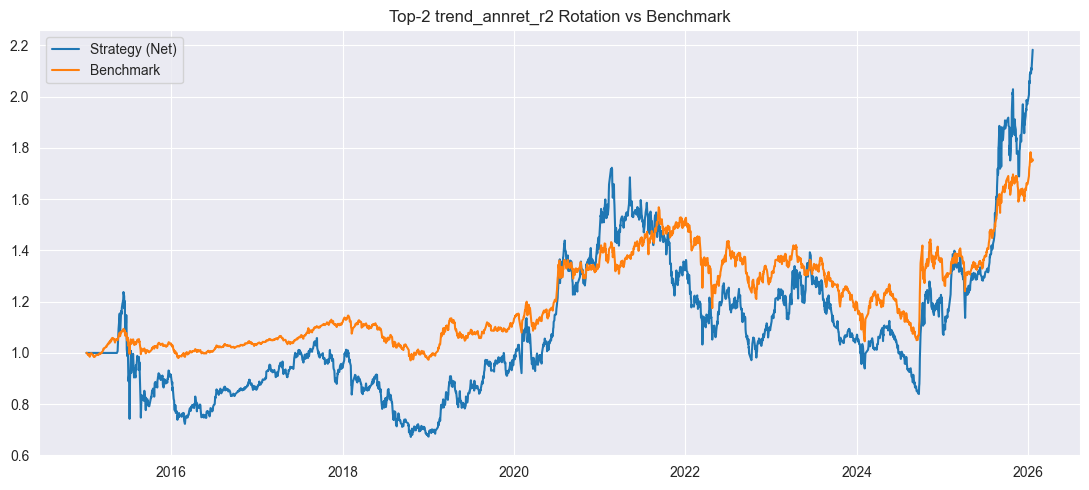

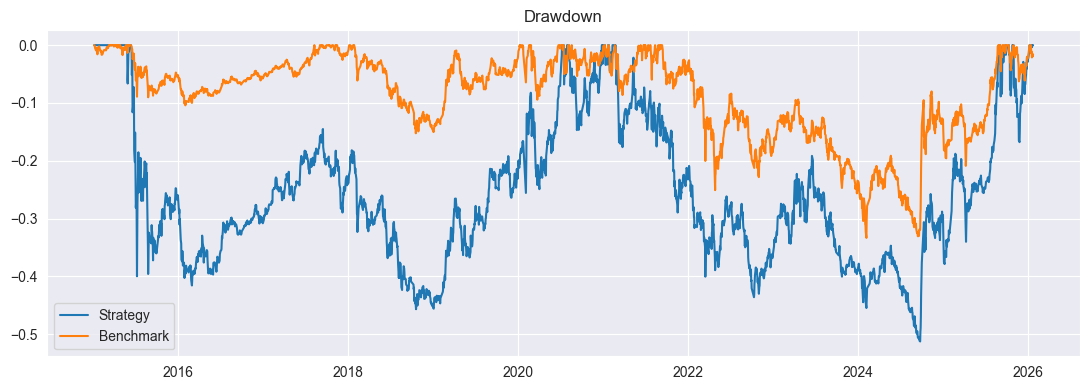

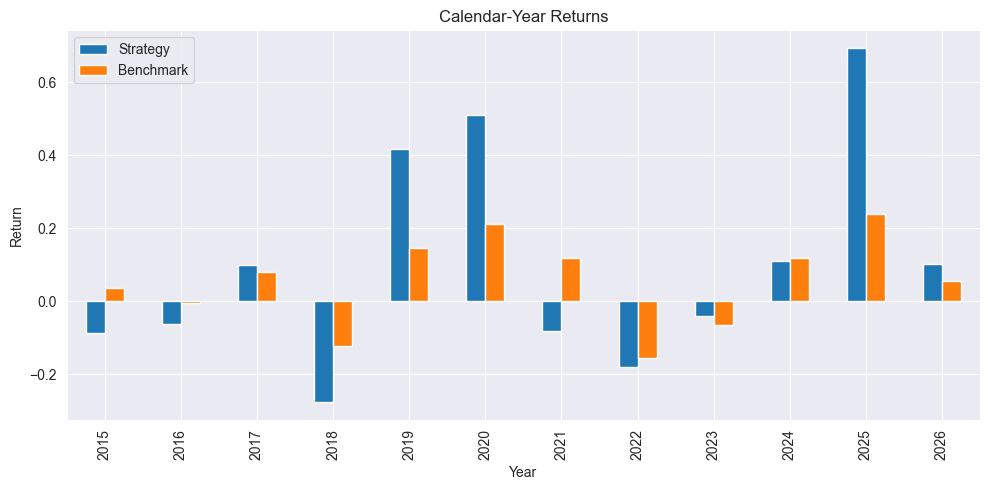

In [54]:
tickers = pd.read_csv(DATA_DIR / 'meta_universe_valid.csv')['code'].values

cfg = ExperimentConfig(
    start="2015-01-01",
    end=None,
    top_k=2,
    fee_bps=2.0,
    rebalance_mode="calendar",
    rebalance="W-FRI",
    benchmark_mode="equal_weight_all",
    signal_name="trend_annret_r2",
    signal_params={"lookback": 63, "skip": 21},
)

# 1) parquet -> MarketData
market_data = load_marketdata_from_parquet(
    data_dir=DATA_DIR,
    tickers=['510880', '159928', '510410', '512010', '502023', '512660', '512580', '161037', '512200', '512980', '515880', '159995', '159996', '159998', '159825', '161724', '513180', '516910', '516970', '159766'],
    start=cfg.start,
    end=cfg.end,
    strict_calendar=False,
)

# 2) run your existing backtest pipeline unchanged
out = run_one(market_data, cfg)

# 3) reporting (unchanged)
print(out["stats"])
print(yearly_returns(out["strat"].net_ret))

plot_compare(
    eq_s=out["strat"].equity_net,
    eq_b=out["bench"].equity_net,
    ret_s=out["strat"].net_ret,
    ret_b=out["bench"].net_ret,
    title=f"Top-{cfg.top_k} {cfg.signal_name} Rotation vs Benchmark",
)
plt.show()

In [47]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

processed_dir = get_processed_dir()

# -----------------------------
# Config
# -----------------------------
@dataclass
class UniverseDiagConfig:    
    path = DATA_DIR / 'ohlcv_wide_close.parquet'

    start: str = "2015-01-01"
    end: Optional[str] = None

    freq: str = "W-FRI"          # weekly for correlation
    min_obs: int = 26            # minimum weeks required (0.5 year)
    corr_method: str = "pearson" # or "spearman"

    # clustering / selection
    target_n: int = 9           # desired universe size
    linkage_method: str = "average"  # 'average' or 'ward' (ward requires Euclidean distances; average is safe)
    corr_threshold: float = 0.90     # fallback greedy redundancy threshold

    # rolling stability
    roll_window_weeks: int = 26


# -----------------------------
# Load + slice
# -----------------------------
def load_close_wide(cfg: UniverseDiagConfig) -> pd.DataFrame:
    path = cfg.path
    close = pd.read_parquet(path)
    if not isinstance(close.index, pd.DatetimeIndex):
        close.index = pd.to_datetime(close.index, errors="coerce")
    close = close[~close.index.isna()].sort_index()
    close.columns = close.columns.astype(str)

    start = pd.to_datetime(cfg.start)
    end = pd.to_datetime(cfg.end) if cfg.end is not None else close.index.max()
    close = close.loc[(close.index >= start) & (close.index <= end)]
    return close


# -----------------------------
# Step 1: availability report
# -----------------------------
def availability_report(close: pd.DataFrame) -> pd.DataFrame:
    rep = []
    for t in close.columns:
        s = close[t]
        non_na = s.dropna()
        rep.append(
            {
                "ticker": t,
                "start_date": non_na.index.min() if len(non_na) else pd.NaT,
                "end_date": non_na.index.max() if len(non_na) else pd.NaT,
                "n_obs": int(non_na.shape[0]),
                "missing_rate": float(s.isna().mean()),
            }
        )
    out = pd.DataFrame(rep).sort_values(["n_obs", "missing_rate"], ascending=[False, True]).reset_index(drop=True)
    return out


# -----------------------------
# Step 2: returns
# -----------------------------
def to_returns(close: pd.DataFrame) -> pd.DataFrame:
    # close-to-close returns
    ret = close.pct_change()
    return ret


def to_weekly_returns(ret_daily: pd.DataFrame, freq: str) -> pd.DataFrame:
    # compound daily returns into weekly (Fri close-to-close by default)
    # 1 + weekly_ret = prod(1 + daily_ret) over the week
    weekly = (1.0 + ret_daily).resample(freq).prod(min_count=1) - 1.0
    return weekly


# -----------------------------
# Step 3: correlation
# -----------------------------
def corr_matrix(ret: pd.DataFrame, method: str = "pearson", min_obs: int = 52) -> pd.DataFrame:
    """
    Correlation computed pairwise with min_periods=min_obs.
    """
    c = ret.corr(method=method, min_periods=min_obs)
    return c


def corr_summary(corr: pd.DataFrame) -> pd.DataFrame:
    """
    For each ticker: max_corr_to_others, mean_corr_to_others
    """
    tickers = corr.columns
    out = []
    for t in tickers:
        s = corr[t].drop(index=t, errors="ignore")
        out.append(
            {
                "ticker": t,
                "mean_corr": float(s.mean(skipna=True)),
                "max_corr": float(s.max(skipna=True)),
                "min_corr": float(s.min(skipna=True)),
                "n_pairs": int(s.notna().sum()),
            }
        )
    return pd.DataFrame(out).sort_values(["max_corr", "mean_corr"], ascending=[False, False]).reset_index(drop=True)


# -----------------------------
# Step 4: clustering (scipy preferred)
# -----------------------------
def corr_to_distance(corr: pd.DataFrame) -> pd.DataFrame:
    """
    Convert correlation to a metric-ish distance.
    d = sqrt(0.5*(1 - corr))
    """
    dist = np.sqrt(0.5 * (1.0 - corr.clip(-1, 1)))
    return dist


def cluster_by_corr(corr: pd.DataFrame, cfg: UniverseDiagConfig) -> pd.Series:
    """
    Returns: cluster_id per ticker (1..k)
    """
    tickers = corr.columns.tolist()
    # Ensure full matrix numeric
    corr2 = corr.copy()
    corr2 = corr2.fillna(0.0)  # conservative: missing => 0 corr (distance high)
    np.fill_diagonal(corr2.values, 1.0)

    dist = corr_to_distance(corr2)
    # squareform expects condensed distance vector
    condensed = squareform(dist.values, checks=False)
    Z = linkage(condensed, method=cfg.linkage_method)
    # Cut to target_n clusters (or fewer if not enough assets)
    k = min(cfg.target_n, len(tickers))
    labels = fcluster(Z, t=k, criterion="maxclust")
    return pd.Series(labels, index=tickers, name="cluster")
    

# -----------------------------
# Step 5: representative selection
# -----------------------------
def pick_representatives(
    clusters: pd.Series,
    avail: pd.DataFrame,
    corr: pd.DataFrame,
    target_n: int,
) -> List[str]:
    """
    Select one representative per cluster, using non-liquidity deterministic rules:
      1) max n_obs (history length)
      2) min missing_rate
      3) min mean correlation within cluster
    Then keep up to target_n clusters with best representatives.
    """
    avail_idx = avail.set_index("ticker")

    reps = []
    for cid, members in clusters.groupby(clusters).groups.items():
        members = list(members)

        # Build candidate table
        cand = []
        for t in members:
            n_obs = float(avail_idx.loc[t, "n_obs"]) if t in avail_idx.index else -1
            miss = float(avail_idx.loc[t, "missing_rate"]) if t in avail_idx.index else 1.0

            # mean corr to cluster peers
            peers = [p for p in members if p != t]
            if peers:
                mean_in = float(corr.loc[t, peers].mean(skipna=True))
            else:
                mean_in = np.nan
            cand.append((t, n_obs, miss, mean_in))

        cdf = pd.DataFrame(cand, columns=["ticker", "n_obs", "missing_rate", "mean_corr_in_cluster"])
        cdf = cdf.sort_values(
            ["n_obs", "missing_rate", "mean_corr_in_cluster"],
            ascending=[False, True, True],
            na_position="last",
        )
        reps.append(cdf.iloc[0].to_dict())

    reps_df = pd.DataFrame(reps)

    # Prefer clusters whose representative has longer history and lower missing
    reps_df = reps_df.sort_values(["n_obs", "missing_rate"], ascending=[False, True]).reset_index(drop=True)
    selected = reps_df.head(min(target_n, len(reps_df)))["ticker"].tolist()
    return selected


# -----------------------------
# Step 6: rolling correlation stability (optional output)
# -----------------------------
def rolling_pair_corr(
    ret_weekly: pd.DataFrame,
    a: str,
    b: str,
    window: int,
) -> pd.Series:
    x = ret_weekly[a]
    y = ret_weekly[b]
    return x.rolling(window).corr(y)


# -----------------------------
# End-to-end runner
# -----------------------------
def diagnose_universe(
    cfg: UniverseDiagConfig,
    tickers: Optional[List[str]] = None,
) -> Dict[str, object]:
    close = load_close_wide(cfg)
    if tickers is not None:
        tickers = [str(t) for t in tickers]
        missing = [t for t in tickers if t not in close.columns]
        if missing:
            raise KeyError(f"Tickers not in parquet close columns: {missing}")
        close = close[tickers].copy()

    # 1) availability
    avail = availability_report(close)

    # 2) returns
    ret_d = to_returns(close)
    ret_w = to_weekly_returns(ret_d, cfg.freq)

    # enforce min weekly obs at the asset level (for stable corr)
    ok = ret_w.notna().sum() >= cfg.min_obs
    ret_w2 = ret_w.loc[:, ok].copy()

    # 3) correlation
    corr_w = corr_matrix(ret_w2, method=cfg.corr_method, min_obs=cfg.min_obs)
    summary = corr_summary(corr_w)

    # 4) clustering
    clusters = cluster_by_corr(corr_w, cfg)

    # 5) representatives
    selected = pick_representatives(clusters, avail, corr_w, cfg.target_n)

    # Optional: show top redundant pairs
    # (upper triangle, sort descending)
    pairs = []
    cols = corr_w.columns.tolist()
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            c = corr_w.iloc[i, j]
            if pd.notna(c):
                pairs.append((cols[i], cols[j], float(c)))
    pairs_df = pd.DataFrame(pairs, columns=["a", "b", "corr"]).sort_values("corr", ascending=False).reset_index(drop=True)

    return {
        "close": close,
        "avail": avail,
        "ret_weekly": ret_w2,
        "corr_weekly": corr_w,
        "corr_summary": summary,
        "clusters": clusters.sort_values(),
        "top_pairs": pairs_df,
        "selected_universe": selected,
    }


# -----------------------------
# Example usage
# -----------------------------

cfg = UniverseDiagConfig(
    start="2015-01-01",
    target_n=20,
    min_obs=52,
    freq="W-FRI",
    linkage_method="average",
    corr_threshold=0.90,
    roll_window_weeks=26,
)

out = diagnose_universe(cfg, tickers=tickers)

print("\n=== Availability (top 15) ===")
print(out["avail"].head(15))

print("\n=== Corr summary (most redundant first) ===")
print(out["corr_summary"].head(15))

print("\n=== Top correlated pairs ===")
print(out["top_pairs"].head(20))

print("\n=== Cluster assignment ===")
print(out["clusters"].head(30))

print("\n=== Suggested universe (size=%d) ===" % len(out["selected_universe"]))
print(out["selected_universe"])

# Optional rolling stability for the most redundant pair
top_pair = out["top_pairs"].iloc[0]
a, b = top_pair["a"], top_pair["b"]
roll = rolling_pair_corr(out["ret_weekly"], a, b, window=cfg.roll_window_weeks)
print(f"\nRolling {cfg.roll_window_weeks}W corr for top pair {a}-{b}:")
print(roll.dropna().tail(10))


=== Availability (top 15) ===
    ticker start_date   end_date  n_obs  missing_rate
0   159928 2015-01-05 2026-01-21   2687      0.000000
1   510880 2015-01-05 2026-01-21   2687      0.000000
2   512070 2015-01-05 2026-01-21   2686      0.000372
3   510410 2015-01-05 2026-01-21   2686      0.000372
4   510230 2015-01-05 2026-01-21   2686      0.000372
5   512010 2015-01-05 2026-01-21   2685      0.000744
6   502023 2015-08-24 2026-01-21   2410      0.103089
7   512660 2016-08-08 2026-01-21   2297      0.145143
8   512580 2017-02-28 2026-01-21   2164      0.194641
9   161037 2017-05-11 2026-01-21   2061      0.232974
10  512800 2017-08-03 2026-01-21   2057      0.234462
11  512400 2017-09-01 2026-01-21   2036      0.242278
12  512200 2017-09-25 2026-01-21   2020      0.248232
13  512980 2018-01-19 2026-01-21   1942      0.277261
14  512690 2019-05-06 2026-01-21   1632      0.392631

=== Corr summary (most redundant first) ===
    ticker  mean_corr  max_corr  min_corr  n_pairs
0   51503

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_35788/3089684626.py:72: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = close.pct_change()


In [49]:
out["corr_summary"].sort_values('mean_corr')

,ticker,mean_corr,max_corr,min_corr,n_pairs
24,502023,0.342770,0.686015,0.095274,29
19,161724,0.344200,0.740802,0.124371,29
5,512800,0.368234,0.901381,0.083191,29
18,159995,0.417735,0.765900,0.108773,29
17,515880,0.429435,0.770840,0.132713,29
9,512690,0.429490,0.892669,0.095274,29
22,161037,0.452718,0.718544,0.163756,29
26,159766,0.455749,0.676861,0.222994,29
12,510880,0.468439,0.807724,0.098359,29
20,512980,0.474868,0.737100,0.222891,29
